In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =2.22e-20

nband = 165

ng =4

ng_refs = (/ 2 , 2 /) 

nref =2

nv = 200

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 500 /) 

t_refs = (/ 250 , 250 /) 

tsfc =300

vstar = 1215

data w_diffuse
     &     /1.8 , 1.66 , 1.5 , 1.8/

data wgt
     &     /0.6 , 0.6 , 0.7 , 0.9/

atmosphere_profiles/trp75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

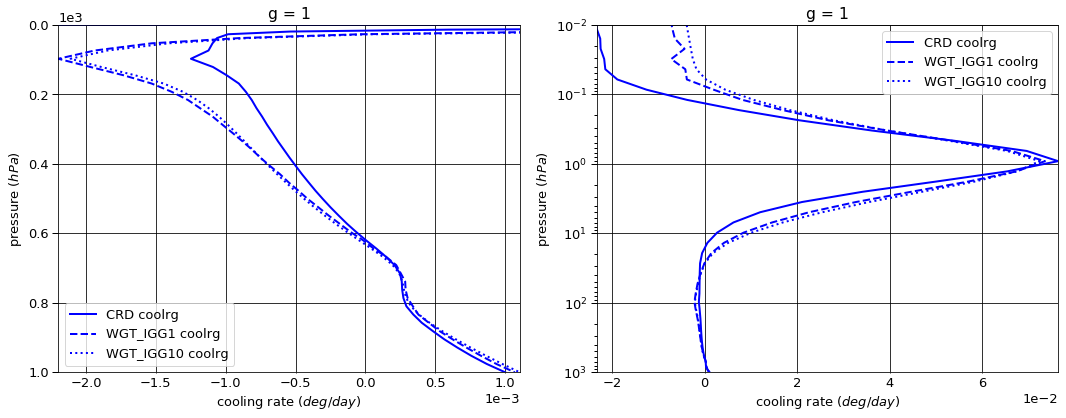

# Figure: cooling rate g-group 2

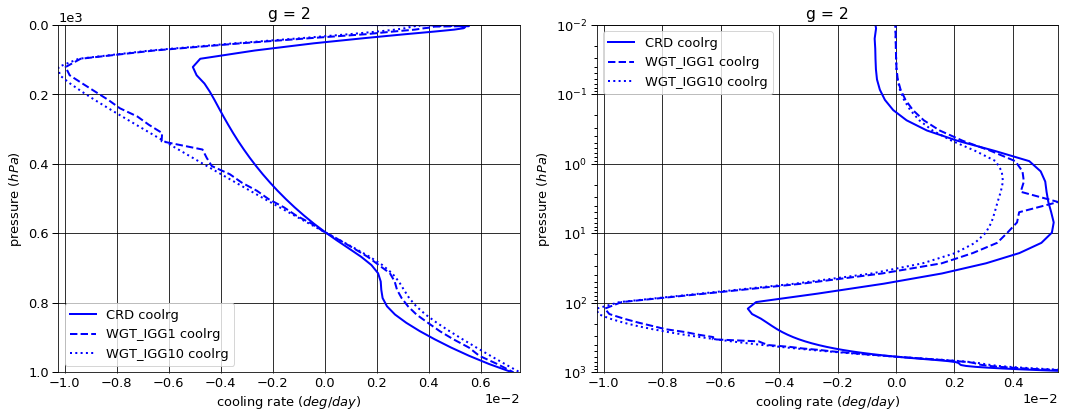

# Figure: cooling rate g-group 3

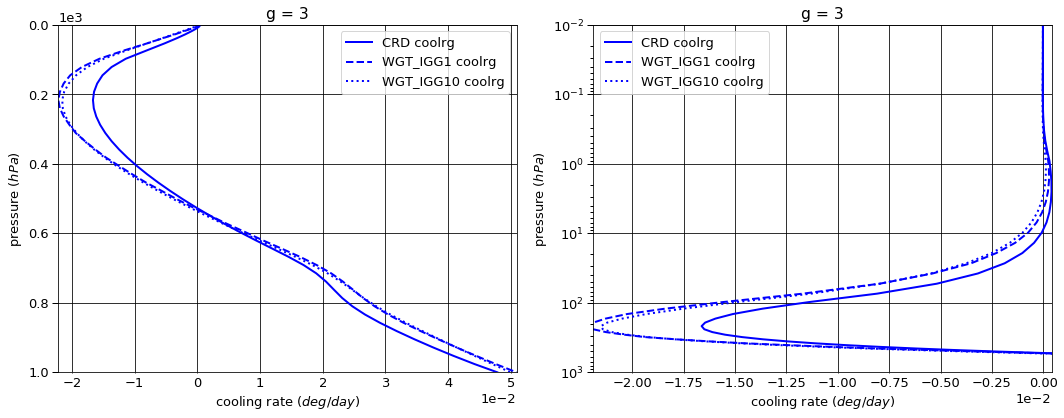

# Figure: cooling rate g-group 4

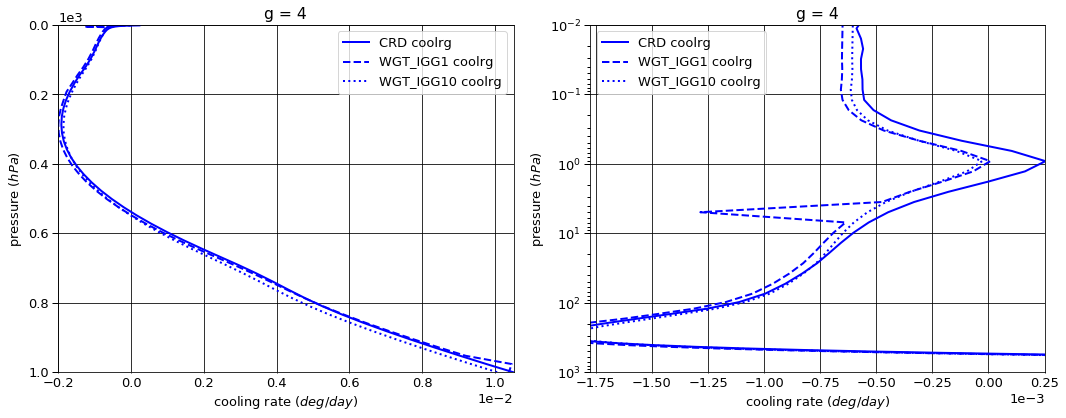

# Figure: cooling rate g-group total

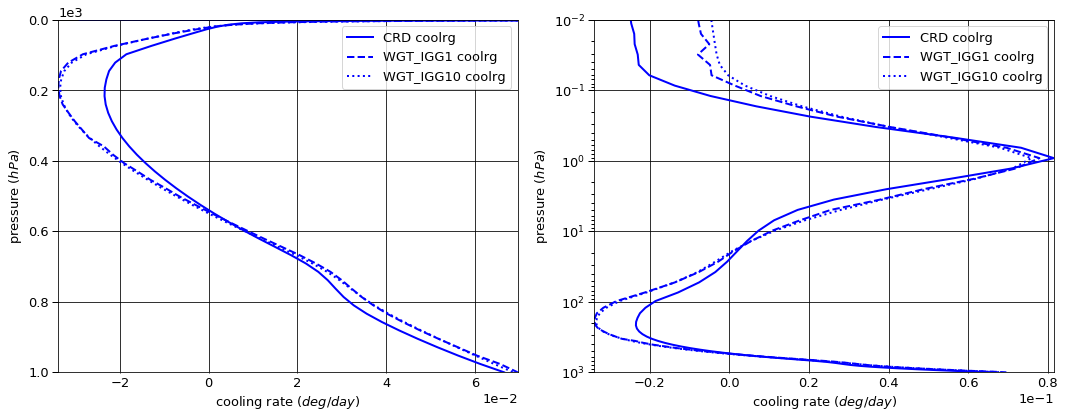

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.053617  0.000000  -0.053617
  1013.0   76     -0.154972  0.099783  -0.055188
2 0.0      1      -0.415382  0.000000  -0.415382
  1013.0   76     -1.107513  0.667935  -0.439578
3 0.0      1      -5.650657  0.000000  -5.650657
  1013.0   76     -8.025718  3.031753  -4.993965
4 0.0      1     -17.406776  0.000000 -17.406776
  1013.0   76    -17.674543  0.455765 -17.218778


WGT_IGG1


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.032771  0.000000  -0.032771
  1013.0   76     -0.154972  0.113630  -0.041342
2 0.0      1      -0.234616  0.000000  -0.234616
  1013.0   76     -1.107513  0.698834  -0.408679
3 0.0      1      -5.390698  0.000000  -5.390698
  1013.0   76     -8.025718  3.211297  -4.814421
4 0.0      1     -17.408849  0.000000 -17.408849
  1013.0   76    -17.674543  0.447688 -17.226855


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.033338  0.000000  -0.033338
  1013.0   76     -0.154972  0.118518  -0.036454
2 0.0      1      -0.206235  0.000000  -0.206235
  1013.0   76     -1.107513  0.714595  -0.392918
3 0.0      1      -5.625892  0.000000  -5.625892
  1013.0   76     -8.025718  2.966380  -5.059338
4 0.0      1     -17.430166  0.000000 -17.430166
  1013.0   76    -17.674543  0.413791 -17.260752


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.020846  0.000000  0.020846
  1013.0   76     0.000000  0.013847  0.013847
2 0.0      1      0.180766  0.000000  0.180766
  1013.0   76     0.000000  0.030899  0.030899
3 0.0      1      0.259959  0.000000  0.259959
  1013.0   76     0.000000  0.179544  0.179544
4 0.0      1     -0.002073  0.000000 -0.002073
  1013.0   76     0.000000 -0.008077 -0.008077


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.020280  0.000000  0.020280
  1013.0   76     0.000000  0.018734  0.018734
2 0.0      1      0.209147  0.000000  0.209147
  1013.0   76     0.000000  0.046660  0.046660
3 0.0      1      0.024765  0.000000  0.024765
  1013.0   76     0.000000 -0.065373 -0.065372
4 0.0      1     -0.023390  0.000000 -0.023390
  1013.0   76     0.000000 -0.041974 -0.041974

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.027682
  1001.112500 75     0.001001
2 0.000312    1     -0.000817
  1001.112500 75     0.007204
3 0.000312    1     -0.000016
  1001.112500 75     0.047823
4 0.000312    1     -0.000551
  1001.112500 75     0.010517


WGT_IGG1


coolrg
g pressure    layer          
1 0.000312    1     -0.010199
  1001.112500 75     0.001070
2 0.000312    1     -0.000065
  1001.112500 75     0.007256
3 0.000312    1     -0.000014
  1001.112500 75     0.050887
4 0.000312    1     -0.000642
  1001.112500 75     0.010388


WGT_IGG10


coolrg
g pressure    layer          
1 0.000312    1     -0.006698
  1001.112500 75     0.001106
2 0.000312    1     -0.000052
  1001.112500 75     0.007499
3 0.000312    1     -0.000014
  1001.112500 75     0.049926
4 0.000312    1     -0.000596
  1001.112500 75     0.010078


WGT_IGG1 - CRD


coolrg
g pressure    layer          
1 0.000312    1      0.017483
  1001.112500 75     0.000069
2 0.000312    1      0.000751
  1001.112500 75     0.000052
3 0.000312    1      0.000002
  1001.112500 75     0.003064
4 0.000312    1     -0.000090
  1001.112500 75    -0.000129


WGT_IGG10 - CRD


coolrg
g pressure    layer          
1 0.000312    1      0.020985
  1001.112500 75     0.000105
2 0.000312    1      0.000764
  1001.112500 75     0.000296
3 0.000312    1      0.000002
  1001.112500 75     0.002104
4 0.000312    1     -0.000045
  1001.112500 75    -0.000439

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-23.526432,0.000000,-23.526432
1013.0,76,-26.962746,4.255236,-22.707510



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-23.066934,0.000000,-23.066934
1013.0,76,-26.962746,4.471448,-22.491297



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-23.295631,0.000000,-23.295631
1013.0,76,-26.962746,4.213284,-22.749462



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.459498,0.000000,0.459498
1013.0,76,0.000000,0.216212,0.216213



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.230801,0.000000,0.230801
1013.0,76,0.000000,-0.041952,-0.041952


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.029066
1001.112500,75,0.066545



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.010920
1001.112500,75,0.069601



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.00736
1001.112500,75,0.06861



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.018146
1001.112500,75,0.003056



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.021706
1001.112500,75,0.002065


In [20]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.005636,0.005770
2,0.040000,0.041342
3,0.290182,0.299459
4,0.664182,0.653430


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,5.539967e-19
2,5.006638e-21
3,2.220810e-20
4,2.164750e-26


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,5.539967e-19,NaN,0.005636,0.005770,0.005636,0.005770,1.0
2,5.006638e-21,9.037306e-03,0.040000,0.041342,0.045636,0.047111,1.0
3,2.220810e-20,4.435731e+00,0.290182,0.299459,0.335818,0.346570,500.0
4,2.164750e-26,9.747570e-07,0.664182,0.653430,1.000000,1.000000,500.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog         ratio        taulyr
layer g pressure                                                           
1     1 0.000312     9.192718e-18  8.020362e-19     11.461725  2.473108e-05
      2 0.000312     1.820267e-20  2.217904e-21      8.207150  5.003791e-08
      3 0.000312     3.711111e-23  3.617313e-23      1.025930  1.560605e-10
      4 0.000312     4.303446e-22  4.655263e-27  92442.600000  1.641172e-09
2     1 0.000750     9.193601e-18  8.046303e-19     11.425870  9.964026e-06
      2 0.000750     1.827555e-20  2.235696e-21      8.174433  2.024138e-08
      3 0.000750     3.760693e-23  3.665802e-23      1.025885  6.369975e-11
      4 0.000750     4.315836e-22  6.156442e-27  70102.774000  6.629458e-10
3     1 0.001052     9.195424e-18  8.097559e-19     11.355797  1.398093e-05
      2 0.001052     1.841042e-20  2.256702e-21      8.158106  2.860003e-08
      3 0.001052     3.833533e-23  3.736545e-23      1.025957  9.105999e-11
      4 0.001052     4.341281e-22  6.929426e-27  62649.937000  9.351870e-10
4     1 0.001476     9.197267e-18  8.150046e-19     11.284927  1.962450e-05
      2 0.001476     1.855189e-20  2.281479e-21      8.131516  4.044104e-08
      3 0.001476     3.914089e-23  3.814929e-23      1.025993  1.304304e-10
      4 0.001476     4.367590e-22  7.760285e-27  56281.310000  1.319917e-09
5     1 0.002070     9.199101e-18  8.203192e-19     11.214050  2.754026e-05
      2 0.002070     1.869941e-20  2.311041e-21      8.091337  5.719464e-08
      3 0.002070     4.003971e-23  3.902584e-23      1.025979  1.871417e-10
      4 0.002070     4.394428e-22  8.638168e-27  50872.227000  1.862675e-09
6     1 0.002904     9.200921e-18  8.257156e-19     11.142967  3.865324e-05
      2 0.002904     1.885462e-20  2.347135e-21      8.033036  8.093969e-08
      3 0.002904     4.106520e-23  4.002852e-23      1.025899  2.692404e-10
      4 0.002904     4.421798e-22  9.549750e-27  46302.758000  2.629119e-09
7     1 0.004074     9.202721e-18  8.312171e-19     11.071381  5.425215e-05
      2 0.004074     1.901983e-20  2.392075e-21      7.951183  1.146253e-07
      3 0.004074     4.226440e-23  4.120432e-23      1.025727  3.887316e-10
      4 0.004074     4.449707e-22  1.049130e-26  42413.314000  3.711337e-09
8     1 0.005714     9.204492e-18  8.368606e-19     10.998836  7.614157e-05
      2 0.005714     1.919838e-20  2.448860e-21      7.839721  1.624704e-07
      3 0.005714     4.370369e-23  4.261954e-23      1.025438  5.638817e-10
      4 0.005714     4.478185e-22  1.146862e-26  39047.296000  5.239137e-09
9     1 0.008015     9.206221e-18  8.426914e-19     10.924784  1.068663e-04
      2 0.008015     1.939477e-20  2.521249e-21      7.692522  2.305762e-07
      3 0.008015     4.547534e-23  4.436637e-23      1.024996  8.231337e-10
      4 0.008015     4.507237e-22  1.249004e-26  36086.643000  7.396693e-09
10    1 0.011243     9.207891e-18  8.487771e-19     10.848421  1.499887e-04
      2 0.011243     1.961542e-20  2.613843e-21      7.504438  3.277616e-07
      3 0.011243     4.770939e-23  4.657461e-23      1.024365  1.211547e-09
      4 0.011243     4.536893e-22  1.356014e-26  33457.579000  1.044357e-08
11    1 0.015771     9.209477e-18  8.552105e-19     10.768666  2.105182e-04
      2 0.015771     1.986932e-20  2.732059e-21      7.272652  4.669185e-07
      3 0.015771     5.058806e-23  4.942610e-23      1.023509  1.802443e-09
      4 0.015771     4.567183e-22  1.467777e-26  31116.336000  1.474718e-08
12    1 0.022122     9.210942e-18  8.621211e-19     10.684046  2.954790e-04
      2 0.022122     2.016903e-20  2.882103e-21      6.998024  6.670209e-07
      3 0.022122     5.436716e-23  5.317584e-23      1.022404  2.718043e-09
      4 0.022122     4.598154e-22  1.583824e-26  29031.967000  2.082628e-08
13    1 0.031031     9.212244e-18  8.697045e-19     10.592384  4.147416e-04
      2 0.031031     2.053268e-20  3.071039e-21      6.685906  9.563764e-07
      3 0.031031     5.940794e-23  5.818341e-23      1.021046  4.167767e-0

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
